In [2]:
%run ./_setup.ipynb

# Radar rain data

## Download radar data for each day of the storm

In [3]:
# create directory
os.makedirs(baser, exist_ok=True)

# read in August files
days = np.arange(25, 32)
# check for first file
if os.path.exists('%s/nws_precip_1day_20170825_conus.nc' % baser):
    for day in days:
        url = 'https://water.weather.gov/precip/downloads/2017/08/%i/nws_precip_1day_201708%i_conus.nc' % (day, day)
        fname = url.split('/')[-1]

        # this will download the file to the present file location
        !wget $url
        # move it to data directory
        %mv $fname $baser
    
# read in September files
days = np.arange(1, 12)
# check for last file
if os.path.exists('%s/nws_precip_1day_20170911_conus.nc' % baser):
    for day in days:
        url = 'https://water.weather.gov/precip/downloads/2017/09/%s/nws_precip_1day_201709%s_conus.nc' % (str(day).zfill(2), str(day).zfill(2))
        fname = url.split('/')[-1]

        # this will download the file to the present file location
        !wget $url
        # move it to data directory
        %mv $fname $baser

--2019-11-04 10:26:09--  https://water.weather.gov/precip/downloads/2017/08/25/nws_precip_1day_20170825_conus.nc
Resolving water.weather.gov (water.weather.gov)... 104.73.167.46
Connecting to water.weather.gov (water.weather.gov)|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4051253 (3.9M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170825_conus.nc’

nws_precip_1day_201 100%[===================>]   3.86M  11.9MB/s    in 0.3s    

2019-11-04 10:26:09 (11.9 MB/s) - ‘nws_precip_1day_20170825_conus.nc’ saved [4051253/4051253]

--2019-11-04 10:26:10--  https://water.weather.gov/precip/downloads/2017/08/26/nws_precip_1day_20170826_conus.nc
Resolving water.weather.gov (water.weather.gov)... 104.73.167.46
Connecting to water.weather.gov (water.weather.gov)|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3995246 (3.8M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170826_conus.nc’

nws_precip_1day_

HTTP request sent, awaiting response... 200 OK
Length: 3533005 (3.4M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170908_conus.nc’

nws_precip_1day_201 100%[===================>]   3.37M  11.9MB/s    in 0.3s    

2019-11-04 10:26:22 (11.9 MB/s) - ‘nws_precip_1day_20170908_conus.nc’ saved [3533005/3533005]

--2019-11-04 10:26:22--  https://water.weather.gov/precip/downloads/2017/09/09/nws_precip_1day_20170909_conus.nc
Resolving water.weather.gov (water.weather.gov)... 104.73.167.46
Connecting to water.weather.gov (water.weather.gov)|104.73.167.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3635242 (3.5M) [application/x-netcdf]
Saving to: ‘nws_precip_1day_20170909_conus.nc’

nws_precip_1day_201 100%[===================>]   3.47M  11.8MB/s    in 0.3s    

2019-11-04 10:26:22 (11.8 MB/s) - ‘nws_precip_1day_20170909_conus.nc’ saved [3635242/3635242]

--2019-11-04 10:26:23--  https://water.weather.gov/precip/downloads/2017/09/10/nws_precip_1day_20170910

## Read in files and save

Select just the area around Texas and save all radar data together into a .nc file.

In [4]:
Files = sorted(glob('%s/nws_precip_1day_20170???_conus.nc' % baser))
# File = Files[0]
# Read in rain data
# ds = xr.open_dataset(File)
ds = xr.open_mfdataset(Files, concat_dim='time', combine='nested')


# Just save part around Texas
lonsharvey = [-90, -90, -100, -100]
latsharvey = [35, 25, 25, 35]
# convert box into stereo, which is the projection the rain data is in
llharveystereo = stereo.transform_points(pc, np.array(lonsharvey), np.array(latsharvey))
# save to new file
ds2 = ds['observation'].sel(x=slice(llharveystereo[:,0].min(), llharveystereo[:,0].max()),
                      y=slice(llharveystereo[:,1].max(), llharveystereo[:,1].min()))
                 

# Set up x and y locations
X, Y = np.meshgrid(ds2['x'].values, ds2['y'].values)

# convert x and y locations to aea projection
rainaea = aea.transform_points(stereo, X, Y)
xrainaea = rainaea[:,:,0]; yrainaea = rainaea[:,:,1]
# combine together
xrainaea2 = np.hstack(((xrainaea[:,0]-abs(xrainaea[:,0]-xrainaea[:,1]))[:,np.newaxis],xrainaea))
yrainaea2 = np.vstack(((yrainaea[0,:]+abs(yrainaea[0,:]-yrainaea[1,:]))[np.newaxis,:],yrainaea))

# calculate rain grid cell area
da = abs(xrainaea2[:,1:] - xrainaea2[:,:-1]) * abs(yrainaea2[1:,:] - yrainaea2[:-1,:])
# change to xarray format
da = xr.DataArray(da,coords=[ds2.y,ds2.x],dims=['y','x'])

# convert rain array to m^3
ds2['rain'] = ds2*2.54/100
ds2.attrs = {'units': 'm', 'name': 'radar rain'}
ds2['da'] = da
ds2.attrs = {'units': 'm^2', 'name': 'grid cell area associated with rain'}

fname = '%s/radar_rain_combined.nc' % baser
if not os.path.exists(fname):
    ds2.to_netcdf(fname)

## Separate into regions

Create shapely points

In [5]:
# create Shapely Shapes out of rain grid cells
# ds['x'], ds['y']
rainpts = []
for x, y, a in zip(xrainaea.flatten(), yrainaea.flatten(), da.values.flatten()):
    rainpts.append(shapely.geometry.Point(x,y))
    
# flattened index to match rainpts
irainpts = np.arange(len(rainpts))

Separate radar rainfall into regions

In [6]:
fname = '%s/radar.csv' % baser

if not os.path.exists(fname):

    # Find rain in each TWDB basin
    iradar = []  # flattened indices identifying rainpts that are in this region
    radar = pd.DataFrame(index=idgb + ['west', 'trinity', 'all'])#, data={'radar rain [m^3]': 0})
    radar['irain'] = [[] for i in range(len(radar.index))]  # to hold list of indices
    radar['rain [m^3]'] = [[] for i in range(len(radar.index))]  # to hold list of rain input
    nt = ds2.time.size  # number of timesteps

    # Loop over TWDB basins first
    for basin in shapes_twdbbasins:

        # save type
        wstype = basin.attributes['WS_type']
        if 'Lake Houston' in wstype: 
            kind = 'Lake Houston (gauged)'
        elif 'Ungauged' in wstype or 'Ungaged' in wstype: 
            kind = 'ungauged'
        elif 'Gauged' in wstype or 'Gaged' in wstype: 
            kind = 'gauged'
        elif 'Bay' in wstype: 
            kind = 'bay'
        else:
            kind = 'unknown'

        basinid = basin.attributes['WS_ID']

        radar.loc[basinid,'kind'] = kind

        for i, rainpt in enumerate(rainpts):  # loop over rain points
            if basin.geometry.contains(rainpt):
                radar.loc[basinid,'irain'].append(i)
        # find radar rain for this region
        # reshape to flatten y/x dimensions to use irain indices
        inds = radar.loc[basinid, 'irain']
        radar.loc[basinid,'rain [m^3]'] = list((ds2['rain'].values*da.values).reshape(nt,-1)[:,inds].sum(axis=1))    

    # Add on other regions
    shapes_west_full_aea = aea.project_geometry(shapes_west_full,pc)
    basinid = 'west'
    radar.loc[basinid,'kind'] = 'radar only'
    for i, rainpt in enumerate(rainpts):  # loop over rain points
        if shapes_west_full_aea.contains(rainpt):
            radar.loc[basinid,'irain'].append(i)   
    inds = radar.loc[basinid, 'irain']
    radar.loc[basinid,'rain [m^3]'] = list((ds2['rain'].values*da.values).reshape(nt,-1)[:,inds].sum(axis=1))

    shapes_trinity_full_aea = aea.project_geometry(shapes_trinity_full,pc)
    basinid = 'trinity'
    radar.loc[basinid,'kind'] = 'gauged (large)'
    for i, rainpt in enumerate(rainpts):  # loop over rain points
        if shapes_trinity_full_aea.contains(rainpt):
            radar.loc[basinid,'irain'].append(i)
    inds = radar.loc[basinid, 'irain']
    radar.loc[basinid,'rain [m^3]'] = list((ds2['rain'].values*da.values).reshape(nt,-1)[:,inds].sum(axis=1))

    shapes_gbay_full_aea = aea.project_geometry(shapes_gbay_full,pc)
    basinid = 'all'
    radar.loc[basinid,'kind'] = 'all'
    for i, rainpt in enumerate(rainpts):  # loop over rain points
        if shapes_gbay_full_aea.contains(rainpt):
            radar.loc[basinid,'irain'].append(i)
    inds = radar.loc[basinid, 'irain']
    radar.loc[basinid,'rain [m^3]'] = list((ds2['rain'].values*da.values).reshape(nt,-1)[:,inds].sum(axis=1))

    # calculate and save total rain
    for ind in radar.index:
        radar.loc[ind,'rain total [m^3]'] = np.sum(radar.loc[ind,'rain [m^3]'])

    # save for future use
    radar.to_csv(fname)

else:
    radar = pd.read_csv(fname, index_col=0)
    # literal_eval allows reading in lists from csv file
    radar['irain'] = radar['irain'].apply(literal_eval)
    radar['rain [m^3]'] = radar['rain [m^3]'].apply(literal_eval)

## Rainfall by region

### Rainfall: full Galveston Bay Watershed

In [10]:
radar.loc['all','rain total [m^3]']/1000**3  # km^3

20.21958057301923

Text(0, 0.5, 'Rainfall [km^3]')

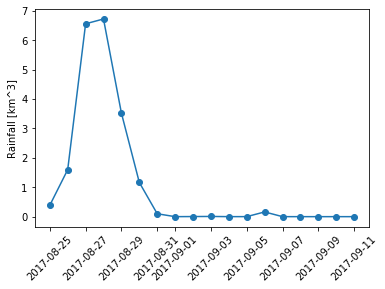

In [27]:
plt.plot(ds.time, np.array(radar.loc['all','rain [m^3]'])/1000**3, marker='o')  # km^3
plt.xticks(rotation=45)
plt.ylabel('Rainfall [km^3]')

### Rainfall: Galveston Bay itself

In [32]:
radar[radar.kind == 'bay']['rain total [m^3]'].sum()/1000**3  # km^3

1.0604595081652326

### Rainfall: Trinity

In [12]:
radar.loc['trinity','rain total [m^3]']/1000**3  # km^3

4.773134133476542

### Rainfall: Lake Houston

In [46]:
radar[radar.kind == 'Lake Houston (gauged)']['rain total [m^3]'].sum()/1000**3  # km^3

4.914720884025304